# Imports

In [5]:
# Freqtrade Workspace

# Notebook Helper
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

# Standard Imports
from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
import attr
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import pandas as pd
import numpy as np

# Resolve CWD
gc.collect()
nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.nbtools.preset import LocalPreset, ConfigPreset, FilePreset, CloudPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
PATH_DATA = PATH_MOUNT / "data"
PATH_PRESETS = PATH_MOUNT / "presets"
PATH_STRATEGIES = PATH_PRESETS / ".strategy_files"
DATALOADER = DataLoader(max_n_datasets=5)

# Define custom functions
def foo() -> str:
    return "bar"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: WANDB_SILENT=true
freqtrade.nbtools.backtest - Initialized DataLoader with 5 max datas.


In [7]:
DATALOADER.clear()

In [2]:
# List of available file strategies
for f in PATH_STRATEGIES.glob("*.py"):
    print(f.name)

AwesomeMacd.py
BigZ04_TSL3.py
BuyAllSellAllStrategy.py
CombinedBinHAndCluc.py
CombinedBinHAndClucV2.py
CombinedBinHAndClucV5.py
CombinedBinHAndClucV6.py
CombinedBinHAndClucV6H.py
CombinedBinHAndClucV7.py
CombinedBinHAndClucV8.py
CombinedBinHAndClucV8Hyper.py
CombinedBinHClucAndMADV6.py
DoesNothingStrategy.py
EnsembleStrategy.py
EnsembleStrategyV1.py
EnsembleStrategyV2.py
GymStrategy.py
NostalgiaForInfinityNext.py
NostalgiaForInfinityV1.py
NostalgiaForInfinityV2.py
NostalgiaForInfinityV3.py
NostalgiaForInfinityV4.py
NostalgiaForInfinityV5.py
NostalgiaForInfinityV6.py
NostalgiaForInfinityV7.py
Obelisk_Ichimoku_ZEMA_v1.py
SMAOffset.py
SMAOffsetProtectOptV0.py
SMAOffsetProtectOptV1.py
SMAOffsetV2.py
SwingHighToSky.py
TheRealPullbackV2.py
TrainCatBoostStrategy.py


# Strategy File Backtesting

In [6]:
strategy_classname = "AwesomeMacd"  # Strategy Filename and Classname must same! 

preset = FilePreset(
    timerange = "20210601-",
    path_to_file = PATH_STRATEGIES / f"{strategy_classname}.py",
    config_dict = configs.DEFAULT,
    path_data = PATH_DATA,
)

# Optional override
preset.overwrite_config(
    pairs=PAIRS_HIGHCAP_NONSTABLE,
    strategy_search_path=PATH_STRATEGIES,
)

stats, summary = backtest(preset, preset.default_strategy_code, clsname=strategy_classname, dataloader=DATALOADER)
trades = pd.DataFrame(stats["strategy"][strategy_classname]["trades"])

Preset name: AwesomeMacd
freqtrade.nbtools.preset.base_preset - Setting config for AwesomeMacd ...
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 62 pairs)
freqtrade.nbtools.preset.base_preset - Add strategy search path C:\CS\Python\crypto-collection\freqtrade\mount\presets\.strategy_files
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210601-
freqtrade.nbtools.backtest - Backtesting...
freqtrade.nbtools.backtest - Strategy using minimal_roi: {'0': 0.1}
freqtrade.nbtools.backtest - Strategy using timeframe: 1h
freqtrade.nbtools.backtest - Strategy using stoploss: -0.25
freqtrade.nbtools.backtest - Strategy using trailing_stop: False
freqtrade.nbtools.backtest - Strategy using trailing_stop_positive_offset: 0.0
freqtrade.nbtools.backtest - Strategy using trailing_only_offset_is_reached: False
freqtrade.nbtools.backtest - St

# Plot Profits

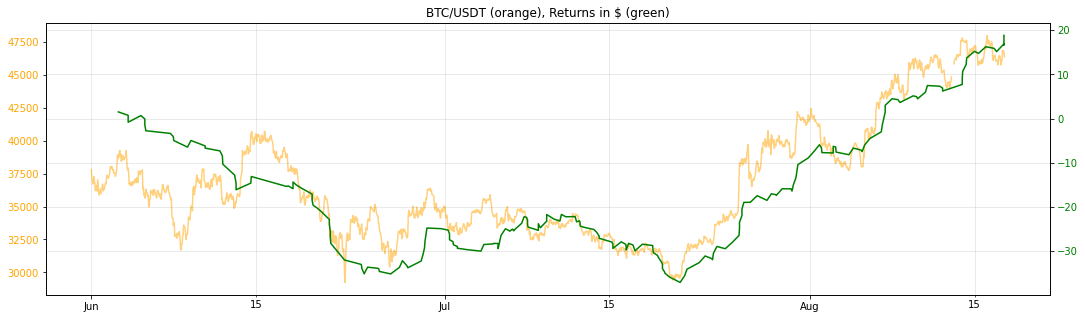

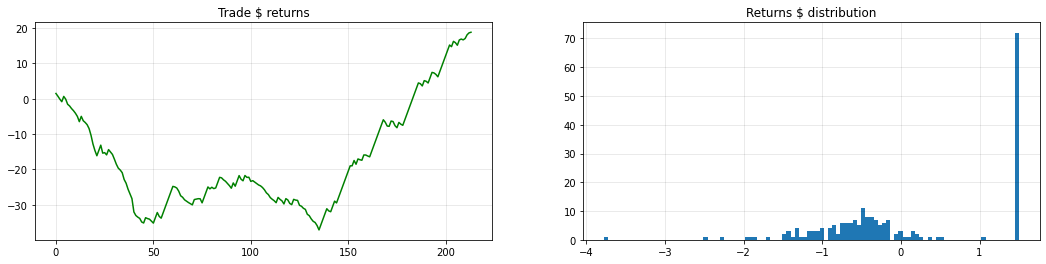

,Portfolio Summary
Min Balance,-37.15
Max Balance,18.85
End Balance,18.85
Trades,214.00
Avg. Profit %,0.59
Avg. Profit $,0.09
Biggest Profit $,1.50
Biggest Loss $,-3.78


freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |                             |
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  |
freqtrade.nbtools.backtest - |                             |
freqtrade.nbtools.backtest - ===============================


In [7]:
plotting.plot_profits(
    trades,
    start = "2021-06-01",
    end = "2021-09-01",
    path_mount = PATH_MOUNT
)

# Statistics

In [82]:
def process_result_dataframe(result_df):
    result_df = result_df.drop(columns=["profit_mean", "profit_total", "profit_sum"])
    result_df = result_df.sort_values(by=["profit_total_abs"], ascending=False)
    result_df = result_df.round(2)
    return result_df

# Running this cell will print backtest results
results = deepcopy(stats["strategy"][strategy_classname])

# Results per pair
results_per_pair = pd.DataFrame(results["results_per_pair"]).set_index("key")
results_per_pair = process_result_dataframe(results_per_pair)

# Sell reason stats
sells = pd.DataFrame(results['sell_reason_summary']).set_index("sell_reason")
sells = process_result_dataframe(sells)

# Left open trades
left_open_trades = pd.DataFrame(results['left_open_trades']).set_index("key")
left_open_trades = process_result_dataframe(left_open_trades)

# Summary metrics
metrics = text_table_add_metrics(results)
advanced_metrics = deepcopy(stats["metadata"])
advanced_metrics["profit_mean"] = advanced_metrics["profit_mean"] * 100
advanced_metrics["profit_median"] = advanced_metrics["profit_median"] * 100
advanced_metrics["profit_total"] = advanced_metrics["profit_total"] * 100

for key in list(advanced_metrics):
    value = advanced_metrics[key]
    valid = any(isinstance(value, it) for it in [str, int, float, bool])
    
    if not valid:
        del advanced_metrics[key]
        continue
    
    if isinstance(value, float):
        advanced_metrics[key] =  round(value, 3)
    
    advanced_metrics[key] = [advanced_metrics[key]]
    
advanced_metrics_df = pd.DataFrame(advanced_metrics)
    
print("Results Per Pair")
display(results_per_pair)
print("Sell Reasons")
display(sells)
print("Left Open Trades")
display(left_open_trades)
print("Freqtrade Summary Metrics")
print("=" * 48 + "\n" + metrics + "\n" + "=" * 48)
print("Advanced Metrics")
print("Preset Name:", advanced_metrics_df["preset_name"][0])
display(advanced_metrics_df.drop(columns=["preset_name"]).T)# Running this cell will print backtest results
results = stats["strategy"]["NotebookStrategy"]

# Results per pair
results_per_pair = pd.DataFrame(results["results_per_pair"])
results_per_pair_df = results_per_pair.set_index("key").drop(columns=["profit_mean", "profit_total"])
results_per_pair_df = results_per_pair_df.sort_values(by=["profit_total_pct"], ascending=False)
results_per_pair_df.round(2)

# Sell reason stats
sells = pd.DataFrame(results['sell_reason_summary'])
sells = sells.drop(columns=["profit_mean", "profit_total"]).set_index("sell_reason")

# Left open trades
left_open_trades = pd.DataFrame(results['left_open_trades'])
left_open_trades = left_open_trades.drop(columns=["profit_mean", "profit_total"]).set_index("key")

# Summary metrics
metrics = text_table_add_metrics(results)

print("Results Per Pair")
display(results_per_pair_df.round(2))
print("Sell Reasons")
display(sells.round(2))
print("Left Open Trades")
display(left_open_trades.round(2))
print("Summary")
print("=" * 48 + "\n" + metrics + "\n" + "=" * 48)

Results Per Pair


,trades,profit_mean_pct,profit_sum,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,,
TOTAL,647,0.76,4.94,493.65,74.12,7.41,0:30:00,418,0,229
DOT/USDT,20,3.13,0.63,62.58,9.40,0.94,0:30:00,12,0,8
ADA/USDT,19,2.64,0.50,50.09,7.52,0.75,0:30:00,16,0,3
THETA/USDT,12,2.75,0.33,32.99,4.95,0.50,0:30:00,11,0,1
QTUM/USDT,19,1.38,0.26,26.31,3.95,0.40,0:30:00,13,0,6
MANA/USDT,6,4.08,0.24,24.46,3.67,0.37,0:30:00,5,0,1
VET/USDT,19,1.13,0.21,21.44,3.22,0.32,0:30:00,13,0,6
KSM/USDT,26,0.79,0.20,20.49,3.08,0.31,0:30:00,15,0,11
MKR/USDT,26,0.72,0.19,18.76,2.82,0.28,0:30:00,19,0,7


Sell Reasons


,trades,wins,draws,losses,profit_mean_pct,profit_sum,profit_sum_pct,profit_total_abs,profit_total_pct
sell_reason,,,,,,,,,
roi,647,418,0,229,0.76,4.94,493.65,74.12,82.27


Left Open Trades


,trades,profit_mean_pct,profit_sum,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,,
TOTAL,0,0.0,0.0,0.0,0.0,0.0,0:00,0,0,0


Summary
| Metric                 | Value               |
|------------------------+---------------------|
| Backtesting from       | 2021-05-01 00:00:00 |
| Backtesting to         | 2021-06-01 00:00:00 |
| Max open trades        | 6                   |
|                        |                     |
| Total/Daily Avg Trades | 647 / 20.87         |
| Starting balance       | 1000.000 USDT       |
| Final balance          | 1074.121 USDT       |
| Absolute profit        | 74.121 USDT         |
| Total profit %         | 7.41%               |
| Avg. stake amount      | 15.000 USDT         |
| Total trade volume     | 9705.000 USDT       |
|                        |                     |
| Best Pair              | DOT/USDT 62.58%     |
| Worst Pair             | LINK/USDT -16.01%   |
| Best trade             | DOT/USDT 31.85%     |
| Worst trade            | UNI/USDT -22.39%    |
| Best day               | 13.632 USDT         |
| Worst day              | -3.420 USDT         |
| Days win/d